# MBS Trend Convexity (Non-Fixed Income Approach)

In this setup we are going to build a model that tries to harvest the MBS but enhacing the short end of the leg. Rather than finding a matched maturity Treasury future candidate and hedging out the duration of the MBS we are going to create a series of trend futures models that are already short treasuries and hedge out the duration. 

In [17]:
import os
import pulp
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
def get_mbs_data() -> pd.DataFrame: 
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    mbs_path = os.path.join(data_path, "MBS.parquet")

    renamer = {
        "LUMSMD": "MBS_mod_dur",
        "LUMSOAS": "MBS_oas",
        "LUMSTRUU": "MBS_index"}

    df_mbs = (pd.read_parquet(
        path = mbs_path, engine = "pyarrow").
        rename(columns = renamer).
        reset_index().
        assign(date = lambda x: pd.to_datetime(x.date).dt.date).
        set_index("date"))
    
    return df_mbs

df_mbs = get_mbs_data()

In [3]:
def get_tsy_data() -> pd.DataFrame: 
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    tsy_path = os.path.join(data_path, "tsy.parquet")

    df_tsy = (pd.read_parquet(
        path = tsy_path, engine = "pyarrow").
        rename(columns = {
            "CONVENTIONAL_CTD_FORWARD_FRSK": "ctd_duration",
            "FUT_EQV_CNVX_NOTL": "ctd_convexity"}).
        assign(date = lambda x: pd.to_datetime(x.date).dt.date).
        set_index("date"))
    
    return df_tsy

df_tsy = get_tsy_data()

## Building Generic MBS basis across all Treasuries

Let's start by building a generic basis across all Treasury Futures contracts. The optimized weights will be used later in the future. 

In [4]:
def _get_duration_weight(df: pd.DataFrame) -> pd.DataFrame: 
    
    print("Working on {}".format(df.name))
    mbs_weights, tsy_weights = [], []
    for i, row in df.iterrows():
        
        duration_problem = pulp.LpProblem(name = "duration_problem", sense = pulp.LpMinimize)
        mbs_weight = pulp.LpVariable(name = "mbs_weight", lowBound = 0.1, upBound = 1)
        tsy_weight = pulp.LpVariable(name = "tsy_weight", lowBound = 0.1, upBound = 1)
        
        duration_problem += (mbs_weight * row.to_dict()["MBS_mod_dur"]) - (tsy_weight * row.to_dict()["ctd_duration"]) == 0
        duration_problem += mbs_weight + tsy_weight == 1
        
        solve = duration_problem.solve()
        mbs_weights.append(pulp.value(mbs_weight))
        tsy_weights.append(pulp.value(tsy_weight))
        
    df_out = (df.assign(
        mbs_weight = mbs_weights,
        tsy_weight = tsy_weights,
        duration_check = lambda x: (x.mbs_weight * x.MBS_mod_dur) - (x.tsy_weight * x.ctd_duration),
        lag_mbs_weight = lambda x: x.mbs_weight.shift(),
        lag_tsy_weight = lambda x: x.tsy_weight.shift(),
        duration_exposure = lambda x: (x.lag_mbs_weight * x.MBS_mod_dur) - (x.lag_tsy_weight * x.ctd_duration)))
    
    return df_out

def _hedge_duration(df_mbs: pd.DataFrame, df_tsy: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df_mbs.drop(
        columns = ["MBS_oas", "MBS_index"]).
        merge(right = df_tsy, how = "inner", on = ["date"]).
        drop(columns = ["PX_LAST"]).
        groupby("security").
        apply(_get_duration_weight).
        drop(columns = ["security"]).
        reset_index())
    
    return df_out

def hedge_duration(df_mbs: pd.DataFrame, df_tsy: pd.DataFrame) -> pd.DataFrame: 
    
    parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    data_path = os.path.join(parent_path, "data")
    weight_path = os.path.join(data_path, "DurationWeights.parquet")
    
    try: df_weight = pd.read_parquet(path = weight_path, engine = "pyarrow")
    except: 
        df_weight = _hedge_duration(df_mbs, df_tsy)
        df_weight.to_parquet(path = weight_path, engine = "pyarrow")

        
    return df_weight

df_duration_hedge = hedge_duration(df_mbs, df_tsy)

In [5]:
def get_duration_hedged_basis(df_mbs: pd.DataFrame, df_tsy: pd.DataFrame, df_duration_hedge: pd.DataFrame) -> pd.DataFrame: 
    
    df_tsy_rtn = (df_tsy.drop(
        columns = ["ctd_duration"]).
        reset_index().
        pivot(index = "date", columns = "security", values = "PX_LAST").
        pct_change().
        reset_index().
        melt(id_vars = "date").
        dropna().
        rename(columns = {"value": "tsy_rtn"}))
    
    df_mbs_rtn = (df_mbs.assign(
        mbs_rtn = lambda x: x.MBS_index.pct_change())
        [["mbs_rtn"]].
        dropna())
    
    df_out = (df_mbs_rtn.merge(
        right = df_duration_hedge, how = "inner", on = ["date"]).
        merge(right = df_tsy_rtn, how = "inner", on = ["date", "security"]).
        assign(basis_rtn = lambda x: (x.mbs_rtn * x.lag_mbs_weight) - (x.tsy_rtn * x.lag_tsy_weight)).
        dropna())
    
    return df_out

df_basis = get_duration_hedged_basis(df_mbs, df_tsy, df_duration_hedge)

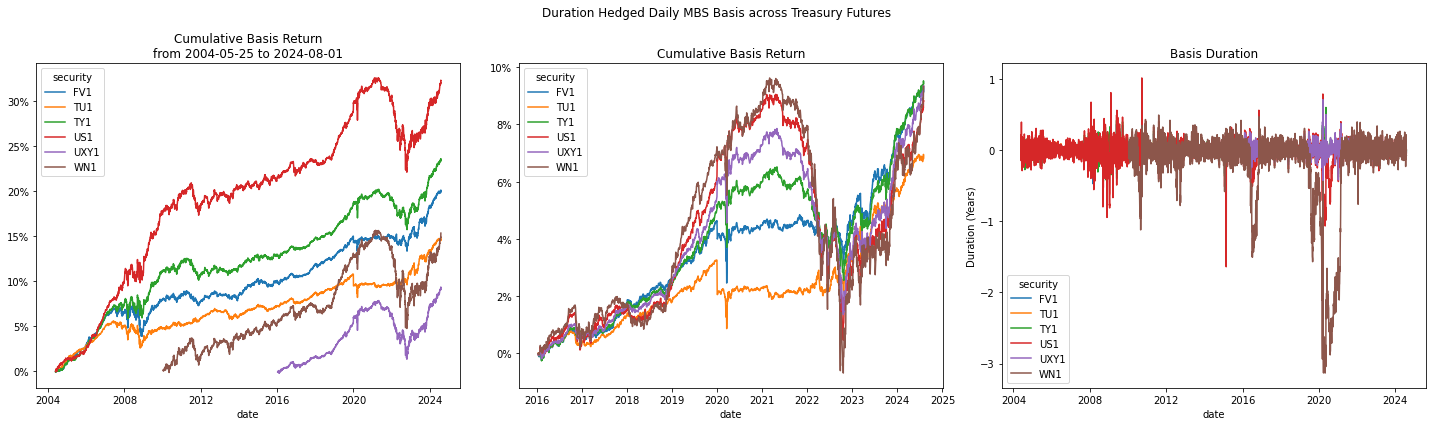

In [ ]:
def plot_basis(df_basis: pd.DataFrame) -> plt.Figure:

    fig, axes = plt.subplots(ncols = 3, figsize = (20,6))

    (df_basis[
        ["date", "security", "basis_rtn"]].
        pivot(index = "date", columns = "security", values = "basis_rtn").
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax = axes[0],
            title = "Cumulative Basis Return\nfrom {} to {}".format(
                df_basis.date.min(),
                df_basis.date.max())))
    
    (df_basis[
        ["date", "security", "basis_rtn"]].
        pivot(index = "date", columns = "security", values = "basis_rtn").
        dropna().
        apply(lambda x: np.cumprod(1 + x) - 1).
        plot(
            ax = axes[1],
            title = "Cumulative Basis Return"))

    (df_basis[
        ["date", "duration_exposure", "security"]].
        pivot(index = "date", columns = "security", values = "duration_exposure").
        plot(
            ax = axes[2],
            title = "Basis Duration",
            ylabel = "Duration (Years)"))

    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    fig.suptitle("Duration Hedged Daily MBS Basis across Treasury Futures")
    plt.tight_layout()
    
plot_basis(df_basis)

Although 1d lagged duration hedges should be somewhat stable its evident that some futures contracts lead to large duration exposures. This occurs because there is a considerable convexity mismatch between the products. 

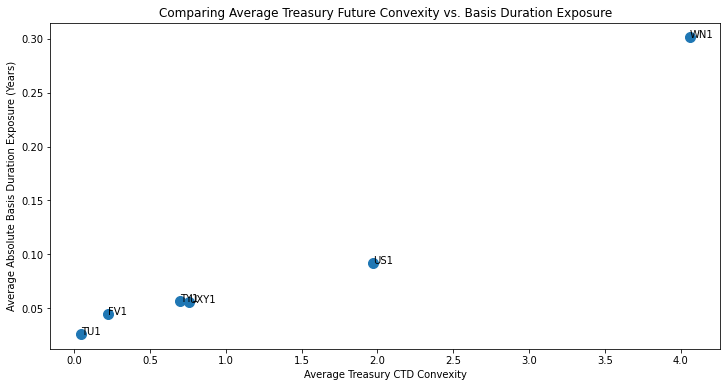

In [ ]:
def plot_convexity_duration(df_tsy: pd.DataFrame, df_basis: pd.DataFrame) -> pd.DataFrame: 
    
    df_avg_convexity = (df_tsy.reset_index()[
        ["security", "ctd_convexity"]].
        groupby("security").
        agg("mean"))

    df_avg_mismatch = (df_basis[
        ["security", "duration_exposure"]].
        assign(duration_exposure = lambda x: np.abs(x.duration_exposure)).
        groupby("security").
        agg("mean"))

    fig, axes = plt.subplots(figsize = (12,6))

    df_plot = (df_avg_convexity.merge(
        right = df_avg_mismatch, how = "inner", on = ["security"]).
        reset_index())

    (df_plot.plot(
        ax = axes,
        s = 100,
        kind = "scatter",
        x = "ctd_convexity",
        y = "duration_exposure",
        xlabel = "Average Treasury CTD Convexity",
        ylabel = "Average Absolute Basis Duration Exposure (Years)",
        title = "Comparing Average Treasury Future Convexity vs. Basis Duration Exposure"))

    for idx, row in df_plot.iterrows():
        axes.annotate(row["security"], (row["ctd_convexity"], row["duration_exposure"]))
        
plot_convexity_duration(df_tsy, df_basis)

In [2]:
import pandas as pd

In [3]:
path = r"C:\Users\Diego\Desktop\app_prod\BBGData\data\SGIXTFIR.parquet"

<AxesSubplot:xlabel='date'>

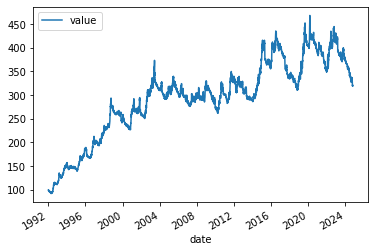

In [5]:
(pd.read_parquet(
    path = path, engine = "pyarrow").
    set_index("date")
    [["value"]].
    plot())